In [39]:
from sklearn.decomposition import PCA
import data_prep as dp
import matplotlib.pyplot as plt
import statistics
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LinearRegression
import datetime as dt
import statsmodels.api as sm
import numpy as np
import pandas as pd
import scipy
import pickle


def itr(ac):
    itr = (np.log2(6)+ ac*np.log2(ac)+ (1-ac)* np.log2((1-ac)/(6-1)))*10
    return itr



pd.set_option('display.max_columns', 1500) 
pd.set_option('display.max_rows', 1500) 

In [19]:
!pip install openpyxl

In [304]:
def boxplot_accuracy(data,name:str):
    means = data.loc[(data.Ep2Avg==8)].groupby("Classifier").mean()["Accuracy"].to_list()
    names = data.loc[(data.Ep2Avg==8)].groupby("Classifier").mean().index.to_list()
    sorted_classifiers = np.array(sorted( zip(means, names)))
    df_list = []
    for classifier in sorted_classifiers[:,1]:
        df = data.loc[(data.Classifier == classifier)& (data.Ep2Avg == 8)]
        df_list.append(df.Accuracy*100)
    fig,ax = plt.subplots(figsize=(8.5,5))
    ax.boxplot(df_list,labels= sorted_classifiers[:,1],widths=0.3)
    ax.set_xticklabels(sorted_classifiers[:,1],rotation=30,ha='right')
    ax.set_ylabel("Accuracy (%)")
    ax.set_ylim(-5,100)
    fig.suptitle("Accuracy " +name)
    plt.savefig(r"C:\Users\map92fg\Documents\Software\P300_Classification\created_data\Graphics\Accuracies\Acc_"+name+".svg",format='svg',bbox_inches="tight",pad_inches=0.2)

def bar_itr(data,name:str):
    fig,ax = plt.subplots(figsize=(16,5))

    means = data.loc[(data.Ep2Avg==8)].groupby("Classifier").mean()["ITR"].to_list()
    names = data.loc[(data.Ep2Avg==8)].groupby("Classifier").mean().index.to_list()
    sorted_classifiers = np.array(sorted( zip(means, names)))
    values = [float(i) for i in sorted_classifiers[:,0]]
    df_list = []

    ax.bar(sorted_classifiers[:,1],values,width =0.25)
    ax.set_xticklabels(sorted_classifiers[:,1],rotation=30,ha='right')
    ax.set_ylabel("ITR (Bits/Minuite)")
    fig.suptitle("ITR " + name)
    plt.savefig(r"D:\Google Drive\Master\Masterarbeit\Graphics\ITR_boxplot_"+name+".png",bbox_inches="tight",pad_inches=0.2)
    
def plot_timeline(tar_df, ntar_df,electrode,title):
    col_list= ["#d8b365","#5ab4ac","#ef8a62","#67a9cf"]
    lr = LinearRegression()

    x = tar_df.index.map(dt.datetime.toordinal).to_numpy()
    x = x.reshape(-1,1)

    fig, ax = plt.subplots(figsize = (12,5))
    y = tar_df["Mean Amplitude"].to_numpy()-ntar_df["Mean Amplitude"].to_numpy()
    y.reshape(-1,1)
    lr.fit(x,y)
    pred = lr.predict(x)
    ax.axvline(x=tar_df.index.values[12],lw=1,alpha=1,zorder=0,c=col_list[2])
    ax.axvline(x=tar_df.index.values[21],lw=1,alpha=1,zorder=0,c=col_list[3])
    tar = ax.bar(tar_df.index,tar_df["Mean Amplitude"], width=1,color=col_list[1])
    ntar = ax.bar(tar_df.index,ntar_df["Mean Amplitude"], width=1,color=col_list[0])
    trend = ax.plot(tar_df.index,pred,c="k",ls=":",lw=0.85)
    lgd =ax.legend(["SetB","Tactilo Relacement","Difference Trend", "Target", "NonTarget"], ncol=5, title=title,loc='center', bbox_to_anchor=(0.5, 1.13),fontsize='small', fancybox=True)
    #ax.set_title(electrode)
    ax.axhline(y=0,c='k',lw=0.5)
    ax.set_ylabel("µV")

    ax.set_xlabel("Session Date")
    #fig.suptitle(title)
    fig.tight_layout
    plt.savefig(r"D:\Google Drive\Master\Masterarbeit\Graphics\Timeline.png",bbox_inches="tight",pad_inches=0.2)

# Amplitudes

In [384]:
def load_session_dates():
    with open(r"C:\Users\map92fg\Documents\Software\P300_Classification\data_thesis\date_dict.pickle", "rb") as file:
        SESS_DATES = pickle.load(file)
    return SESS_DATES

SESS_DATES = load_session_dates()
amp = pd.read_csv(r"C:\Users\map92fg\Documents\Software\P300_Classification\created_data\PUG_average_amplitudes_350_600.csv")
amp["Dates"] = amp["Session"].replace(SESS_DATES)

amp.to_csv(r"C:\Users\map92fg\Documents\Software\P300_Classification\created_data\PUG_average_amplitudes_350_600_with_dates.csv",index=False)


# Load Data

In [608]:
all_acc =  pd.read_csv(r"C:\Users\map92fg\Documents\Software\P300_Classification\created_data\Classifier_Results\accuracies_19_05_22_V2.csv")
all_acc["Condition"] = all_acc["Condition"].map({"sess3":"sess3","sess1":"sess1","single3_A":"single3","single3_B":"single3","single1_A":"single1","single1_B":"single1"}, na_action='ignore')
all_acc.to_csv(r"C:\Users\map92fg\Documents\Software\P300_Classification\created_data\Classifier_Results\PUG_accuracies.csv",index=False)
all_acc["Condition"].isnull().any().sum()

0

In [609]:
#change NaN values very SWLDA 
all_acc.Accuracy = all_acc.Accuracy.fillna(value=0)
all_acc.loc[all_acc.isnull().any(axis=1)]

,Accuracy,Classifier,Session,Condition,Ep2Avg


In [610]:
# for the Pug only session 1-17 are evalutetd, without the xDawn spatial filter and the LDA
pug = all_acc.loc[(~all_acc.Classifier.str.contains("xDawn")) & (all_acc.Session<27) & (all_acc.Classifier!="LDA") & (all_acc.Ep2Avg==8)]

sess3 = pug.loc[pug.Condition=="sess3"]
sess1 = pug.loc[pug.Condition=="sess1"]
single3 = pug.loc[pug.Condition=="single3"]
single1 = pug.loc[pug.Condition=="single1"]


In [611]:
sess1.loc[sess1.Accuracy == 0]

,Accuracy,Classifier,Session,Condition,Ep2Avg
6215,0.0,SWLDA,13,sess1,8
6255,0.0,SWLDA,14,sess1,8
6335,0.0,SWLDA,17,sess1,8


In [612]:
sess3.groupby("Classifier").count()

,Accuracy,Session,Condition,Ep2Avg
Classifier,,,,
FGMDM,17,17,17,17
FGMDM_res,17,17,17,17
MDM,17,17,17,17
MDM_res,17,17,17,17
SWLDA,17,17,17,17
shrinkLDA,17,17,17,17


In [613]:
sess3.groupby("Classifier").mean().sort_values("Accuracy")

,Accuracy,Session,Ep2Avg
Classifier,,,
MDM_res,0.303922,13.764706,8.0
MDM,0.418301,13.764706,8.0
FGMDM,0.454248,13.764706,8.0
SWLDA,0.477124,13.764706,8.0
FGMDM_res,0.519608,13.764706,8.0
shrinkLDA,0.571895,13.764706,8.0


In [614]:
sess1.groupby("Classifier").mean().sort_values("Accuracy")

,Accuracy,Session,Ep2Avg
Classifier,,,
MDM_res,0.297386,13.764706,8.0
FGMDM,0.336601,13.764706,8.0
SWLDA,0.352941,13.764706,8.0
MDM,0.385621,13.764706,8.0
FGMDM_res,0.401961,13.764706,8.0
shrinkLDA,0.457516,13.764706,8.0


In [615]:
single3.groupby("Classifier").mean().sort_values("Accuracy")

,Accuracy,Session,Ep2Avg
Classifier,,,
MDM,0.156863,13.764706,8.0
MDM_res,0.163399,13.764706,8.0
FGMDM_res,0.313725,13.764706,8.0
FGMDM,0.326797,13.764706,8.0
shrinkLDA,0.356209,13.764706,8.0
SWLDA,0.382353,13.764706,8.0


In [616]:
single1.groupby("Classifier").mean().sort_values("Accuracy")

,Accuracy,Session,Ep2Avg
Classifier,,,
MDM,0.156863,13.764706,8.0
MDM_res,0.163399,13.764706,8.0
FGMDM_res,0.313725,13.764706,8.0
FGMDM,0.326797,13.764706,8.0
shrinkLDA,0.356209,13.764706,8.0
SWLDA,0.382353,13.764706,8.0


### Boxplots Accuracy

In [638]:
def boxplot_accuracy(data,name:str,fname:str): #fnme = formatted name
    means = data.loc[(data.Ep2Avg==8)].groupby("Classifier").mean()["Accuracy"].to_list()
    names = data.loc[(data.Ep2Avg==8)].groupby("Classifier").mean().index.to_list()
    sorted_classifiers = np.array(sorted( zip(means, names)))
    df_list = []
    for classifier in sorted_classifiers[:,1]:
        df = data.loc[(data.Classifier == classifier)& (data.Ep2Avg == 8)]
        df_list.append(df.Accuracy*100)
    fig,ax = plt.subplots(figsize=(8.5,5))
    ax.boxplot(df_list,labels= sorted_classifiers[:,1],widths=0.3)
    ax.set_xticklabels(sorted_classifiers[:,1],rotation=15,ha='right')
    ax.set_ylabel("Accuracy (%)")
    ax.set_ylim(-15,100)
    ax.axhline(y=-5,c='k', lw=0.5)
    ax.axvspan(int(np.where(sorted_classifiers[:,1]=="SWLDA")[0]+1)-0.25,int(np.where(sorted_classifiers[:,1]=="SWLDA")[0]+1)+0.25, facecolor="#808080", alpha=0.3)
    for i,mean in enumerate(sorted_classifiers[:,0]):
        ax.text(x=i+0.9,y=-11,s=str(round(float(mean)*100))+"%")
    ax.text(x=.3,y=-11,s="Ø")
    fig.suptitle(fname)
    plt.savefig(r"C:\Users\map92fg\Documents\Software\P300_Classification\created_data\Graphics\Accuracies\Acc_"+name+".svg",format='svg',bbox_inches="tight",pad_inches=0.2)


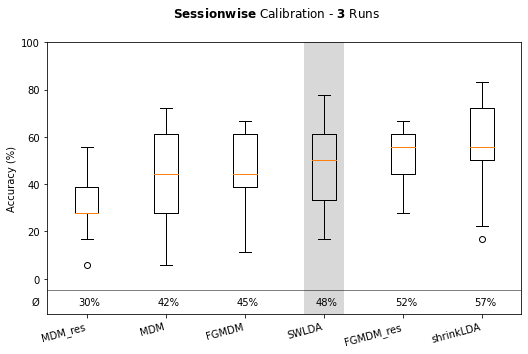

In [639]:
boxplot_accuracy(sess3,r"Sessionwise Calibration - 3 Runs",r"$\bf{Sessionwise}$ Calibration - $\bf{3}$ Runs")

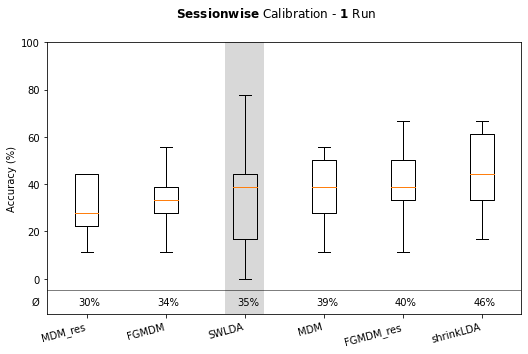

In [644]:
boxplot_accuracy(sess1,"Sessionwise Calibration - 1 Run",r"$\bf{Sessionwise}$ Calibration - $\bf{1}$ Run")

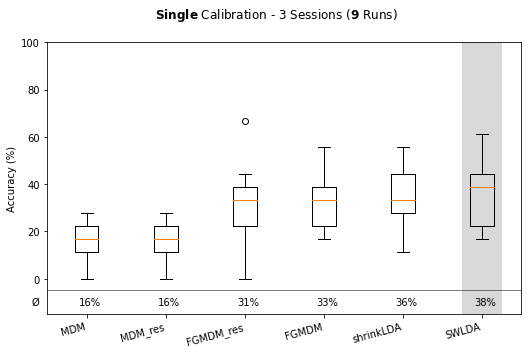

In [643]:
boxplot_accuracy(single3,r"Single Calibration - 3 Sessions (9 Runs)",r"$\bf{Single}$ Calibration - 3 Sessions ($\bf{9}$ Runs)")

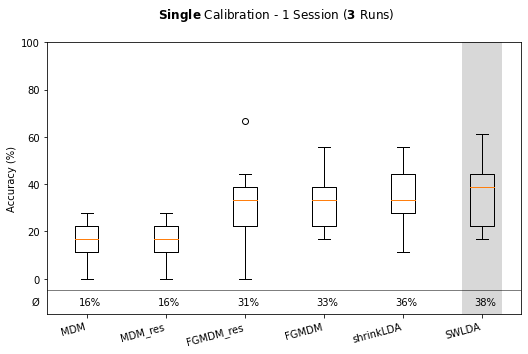

In [642]:
boxplot_accuracy(single1,r"Single Calibration - 1 Session (3 Runs)",r"$\bf{Single}$ Calibration - 1 Session ($\bf{3}$ Runs)")

# Amplitudes

In [ ]:
pd.read_csv(r"D:\Google Drive\Master\Masterarbeit\Data\Investigation\average_amplitudes_350_600.csv").groupby("Electrode").std()

In [ ]:
t_mean = t.groupby('Dates').mean()
t_mean = t_mean.set_index(pd.to_datetime(t_mean.index,dayfirst=True),drop=True)
t_mean = t_mean.sort_index()
nt_mean = nt.groupby('Dates').mean()
nt_mean = nt_mean.set_index(pd.to_datetime(nt_mean.index,dayfirst=True),drop=True)
nt_mean = nt_mean.sort_index()

In [ ]:
t_std = t.groupby('Dates').std()
t_std = t_std.set_index(pd.to_datetime(t_std.index,dayfirst=True),drop=True)
t_std = t_std.sort_index()
nt_std = nt.groupby('Dates').std()
nt_std = nt_std.set_index(pd.to_datetime(nt_std.index,dayfirst=True),drop=True)
nt_std = nt_std.sort_index()

In [ ]:
t_ci = t_std["Mean Amplitude"]*1.96/np.sqrt(6)
nt_ci = nt_std["Mean Amplitude"]*1.96/np.sqrt(6)
t_ci = [(t_mean["Mean Amplitude"]-t_ci).to_list(), (t_mean["Mean Amplitude"]+t_ci).to_list()]
nt_ci = [(nt_mean["Mean Amplitude"]-nt_ci).to_list(), (nt_mean["Mean Amplitude"]+nt_ci).to_list()]

In [354]:
[(t_mean["Mean Amplitude"]-t_ci).to_list(), (t_mean["Mean Amplitude"]+t_ci).to_list()]
[(nt_mean["Mean Amplitude"]-nt_ci).to_list(), (nt_mean["Mean Amplitude"]+nt_ci).to_list()]

[[-0.7105314683453487,
  0.9053744847598102,
  0.7874218432186137,
  -0.42000099550864145,
  0.5110922952468733,
  1.1649889024940467,
  -0.7033696527609828,
  1.272168716324589,
  2.379509901776731,
  2.022208175731102,
  0.8766293320015426,
  0.848418922183546,
  1.0253166692680937,
  0.25589364726201436,
  0.4653473746773571,
  -1.0319614365922782,
  0.7567117610247309],
 [5.03064312255637,
  4.035813359833413,
  3.0446372483337423,
  2.8247666664674425,
  3.1350339330902237,
  4.475791649680516,
  2.636669937590968,
  3.267124504398131,
  3.431088859876848,
  2.8989197271664655,
  2.79983379365197,
  2.278111508140746,
  3.667834441429749,
  3.4433385912417735,
  3.123037087355678,
  1.6008637409807345,
  2.1508897514696996]]

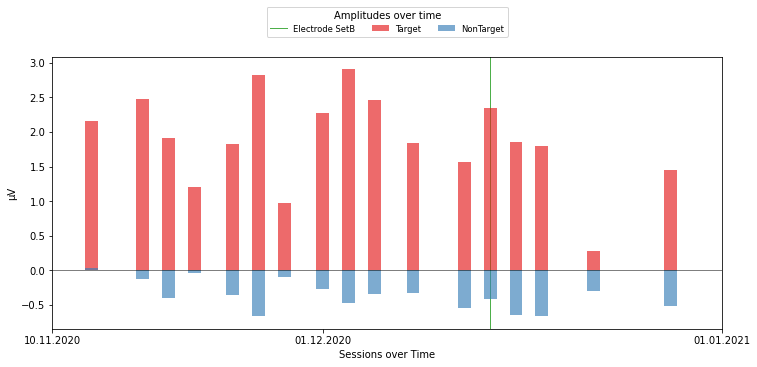

In [46]:
import matplotlib.dates as mdates
def plot_timeline(tar_df, ntar_df,electrode,title):
    col_list= ["#377eb8","#e41a1c","#4daf4a"]
    #lr = LinearRegression()

    # x = tar_df.index.map(dt.datetime.toordinal).to_numpy()
    # x = x.reshape(-1,1)

    fig, ax = plt.subplots(figsize = (12,5))
    #y = tar_df["Mean Amplitude"].to_numpy()-ntar_df["Mean Amplitude"].to_numpy()
    #y.reshape(-1,1)
    #lr.fit(x,y)
    #pred = lr.predict(x)
    ax.axvline(x=tar_df.index.values[12],lw=1,alpha=1,zorder=0,c=col_list[2]) # electrode set b
    tar = ax.bar(tar_df.index,tar_df["Mean Amplitude"], width=1,color=col_list[1],alpha=0.65)
    ntar = ax.bar(tar_df.index,ntar_df["Mean Amplitude"], width=1,color=col_list[0],alpha=0.65)
   # trend = ax.plot(tar_df.index,pred,c="k",ls=":",lw=0.85)
    lgd =ax.legend(["Electrode SetB", "Target",  "NonTarget"], ncol=5, title=title,loc='center', bbox_to_anchor=(0.5, 1.13),fontsize='small', fancybox=True)
    #ax.set_title(electrode)
    ax.axhline(y=0,c='k',lw=0.5)
    ax.set_ylabel("µV")
    ax.set_xticks(pd.DatetimeIndex(["10.11.2020","1.12.2020","1.1.2021"],dayfirst=True))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%d.%m.%Y"))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter("%Y-%m"))
    ax.set_xlabel("Sessions over Time")
    #fig.suptitle(title)
    fig.tight_layout
    plt.savefig(r"C:\Users\map92fg\Documents\Software\P300_Classification\data_thesis\PUG_Timeline.svg",bbox_inches="tight",pad_inches=0.2,format="svg")
plot_timeline(t,nt,"Cz","Amplitudes over time")

In [44]:
nt.describe()

,Session,Tactilo,Mean Amplitude
count,17.000000,17.0,17.000000
mean,13.764706,3.5,-0.360502
std,8.692881,0.0,0.215043
min,1.000000,3.5,-0.666765
25%,6.000000,3.5,-0.510342
50%,14.000000,3.5,-0.350763
75%,22.000000,3.5,-0.266491
max,26.000000,3.5,0.036473


In [45]:
t.describe()

,Session,Tactilo,Mean Amplitude
count,17.000000,17.0,17.000000
mean,13.764706,3.5,1.889695
std,8.692881,0.0,0.670982
min,1.000000,3.5,0.284451
25%,6.000000,3.5,1.563265
50%,14.000000,3.5,1.849616
75%,22.000000,3.5,2.346576
max,26.000000,3.5,2.905299
